escala buena por imagen:

imagen 0

imagen 1: botella --> 0.44



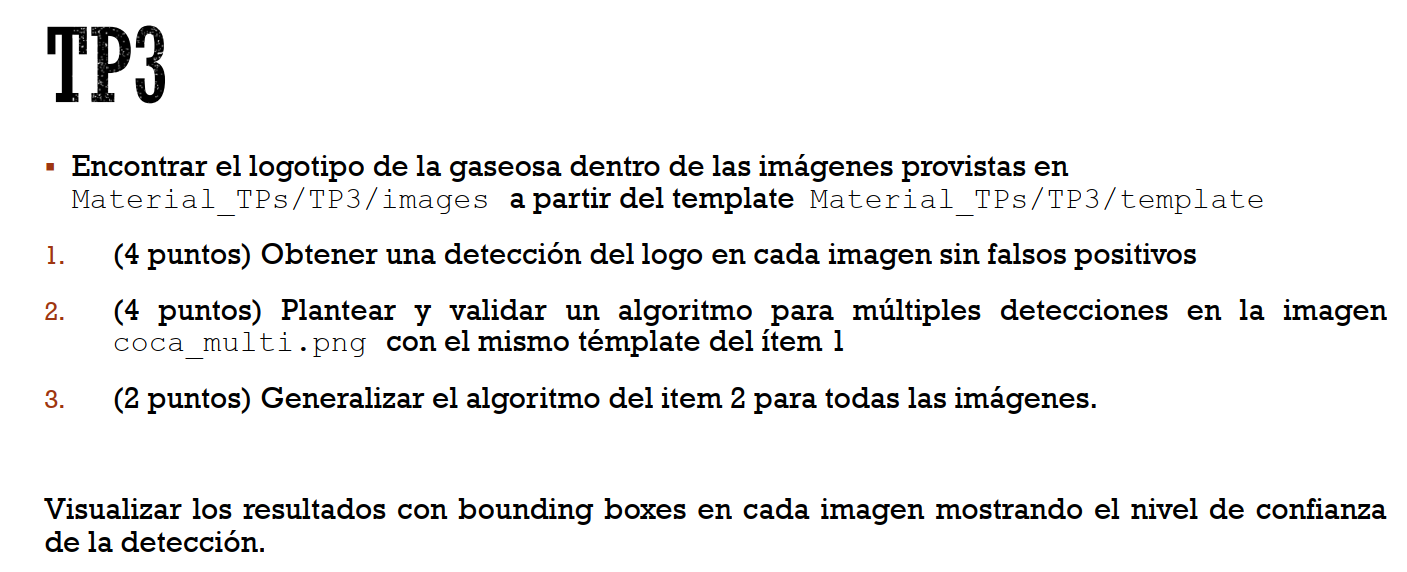

In [8]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline
#%matplotlib

import numpy as np
import cv2 as cv
import cv2
import math
import matplotlib.pyplot as plt
import os

## ---------------------------------- PARTE 1 ----------------------------------

Nombre: COCA-COLA-LOGO.jpg


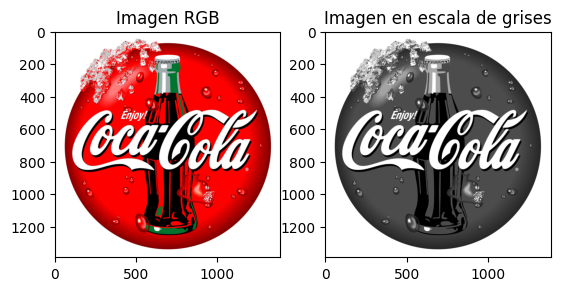

Nombre: coca_logo_1.png


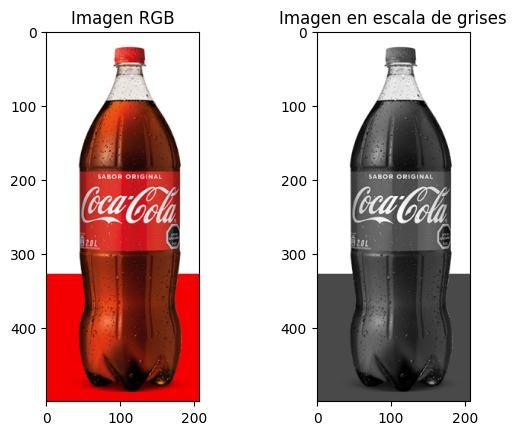

Nombre: coca_logo_2.png


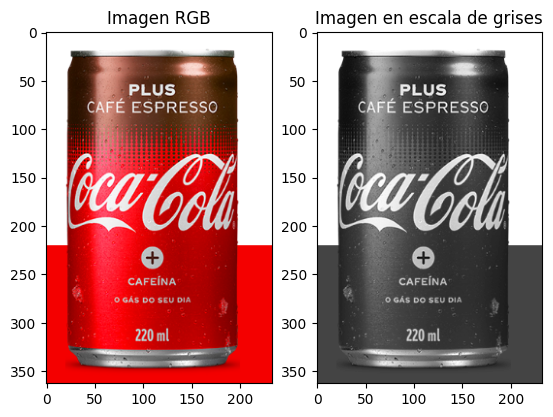

Nombre: coca_multi.png


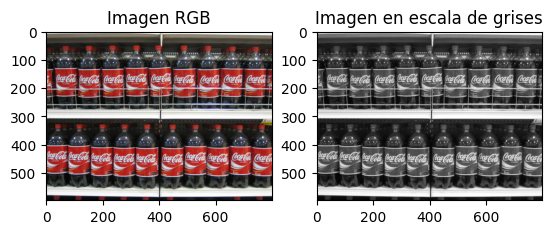

Nombre: coca_retro_1.png


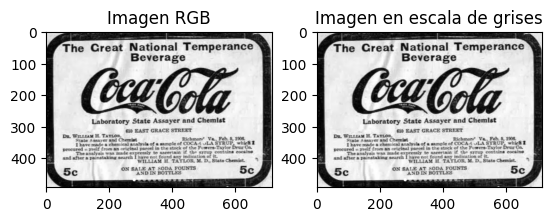

Nombre: coca_retro_2.png


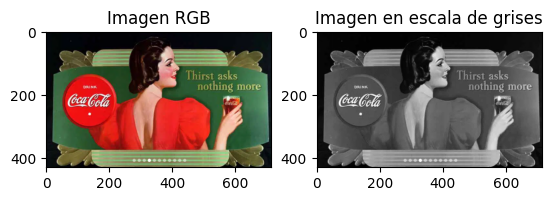

Nombre: logo_1.png


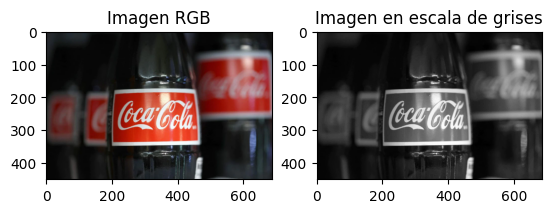

In [9]:
# Carga de las imagenes a procesar

# Ruta de la carpeta de imágenes
folder_path = './images/'  # Ajusta la ruta según la ubicación de tu carpeta

# Lista para almacenar la información de las imágenes
images_info = []

# Recorre los archivos en la carpeta de imágenes
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filtra solo archivos de imagen
        # Lee la imagen
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        if img is not None:
            # Convierte la imagen a RGB y escala de grises
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Guarda la información en un diccionario
            image_data = {
                'nombre': filename,
                'imagen_rgb': img_rgb,
                'imagen_gris': img_gray
            }

            # Agrega el diccionario a la lista
            images_info.append(image_data)

# Acceder a la información de las imágenes cargadas
for image_data in images_info:
    print(f"Nombre: {image_data['nombre']}")
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_data['imagen_rgb'])
    plt.title('Imagen RGB')
    plt.subplot(1, 2, 2)
    plt.imshow(image_data['imagen_gris'], cmap='gray')
    plt.title('Imagen en escala de grises')
    plt.show()


Text(0.5, 1.0, 'Template')

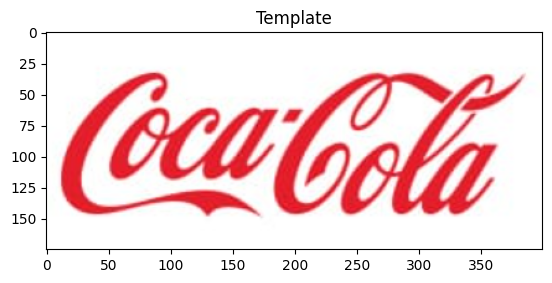

In [10]:
# Carga del template
template = cv.imread('.\\template\\pattern.png')
template_rgb = cv.cvtColor(template, cv.COLOR_BGR2RGB)
template_gray = cv.cvtColor(template, cv2.COLOR_BGR2GRAY)

# Visualizar imagenes y template
plt.figure()
plt.imshow(template_rgb, cmap='gray')
plt.title("Template")


Text(0.5, 1.0, 'template_gray')

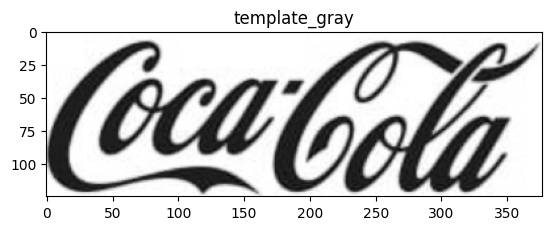

In [11]:
# Recorto el template para dejar eliminar los pixeles que no aportan al logo

template_gray = template_gray[25:150, 11:388]

plt.figure()
plt.imshow(template_gray, cmap='gray')
plt.title("template_gray")

Método de detección del logo

In [12]:
print('template: ', template.shape)
print('template_gray: ', template_gray.shape)
print('template_gray.shape[::-1] ', template_gray.shape[::-1] )

template:  (175, 400, 3)
template_gray:  (125, 377)
template_gray.shape[::-1]  (377, 125)


Definicion de la función de detección de logo. 
Para lograr la detección del logo incorporé:
* *Redimensionamiento del template*: se busca que el tamaño del template sea lo más cercano posible al tamaño del logo en la imagen a procesar.
   Se va probando con una lista de escalas y me quedo con el valor de escalado que arroja el mejor valor de la métrica. Como métrica utilicé los valores min_val y max_val (según corresponda) que devuelve la funcion cv.minMaxLoc(res) luego de realizado el template matching. Por falta de tiempo no pobré otras opciones de métricas como IoU, NMS, etc.
* *Detección de bordes con Canny*: fue necesario realizar este pre-procesamiento para mejorar la detección.


Oportunidades de mejora:

* La funcion solo está pensada para métodos normalizados dada la manera en que se iniciliza la variable auxiliar best_val, queda pendiente generalizar a cualquier método.

* Probar automáticamente distintos métodos de template matching para cada imagen.

* Encontrar manera de no terner que pasar como argumento de la funcion la lista de escalas a probar (list_scale) y los umbrales para el detector de Canny (canny_threshold1 y canny_threshold2), dado que tuve que ir probando valores factibles para cada imagen a procesar.


In [139]:
def detectar_logo(img_gray, img_rgb, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template):
    
    # Carga del método para la detección
    method = eval(metodo)

    # Iteramos sobre diferentes tamaños de la plantilla (mayores y menores) y obtenemos la mejor deteccion

    ## inicializacion de varibles
    if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']:
        best_val = 1
    else:
        best_val = 0
    # Iteracion
    for scale in scale_list:

        # Redimensiono del template
        template_scaled = cv.resize(template_gray, None, fx=scale, fy=scale)
        
        # Si el tamaño de la plantilla es mayor que la imagen, dejamos de iterar
        if template_scaled.shape[0] > img_gray.shape[0] or template_scaled.shape[1] > img_gray.shape[1]:
            print("el tamaño de la plantilla es mayor que la imagen")
            break
        
        # Copia de la imagen color 
        img_salida = img_rgb.copy()

        # Aplico el Detector de Canny a fin de mejorar la deteccion del logo en la imagen
        img_canny = cv.Canny(img_salida, threshold1=canny_threshold1_img, threshold2=canny_threshold2_img)
        template_canny = cv.Canny(template_scaled, threshold1=canny_threshold1_template, threshold2=canny_threshold2_template)

        # Aplico el template matching con el template redimensionada
        res = cv.matchTemplate(img_canny, template_canny, method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        # Busqueda del valore de scale que brinda la mejor detección
        if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']:
            if abs(min_val) < best_val:
                best_val = abs(min_val)
                top_left = min_loc
                best_res = res
                best_template_canny = template_canny
        else:
            if max_val > best_val:
                best_val = max_val
                top_left = max_loc
                best_res = res
                best_template_canny = template_canny
                best_scale = scale

    # Mostrar la detección del logo en la imagen color
    w, h = best_template_canny.shape[::-1]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida, top_left, bottom_right, (0, 0, 255), 3)

    return best_template_canny, img_canny, best_res, img_salida, best_val, best_scale


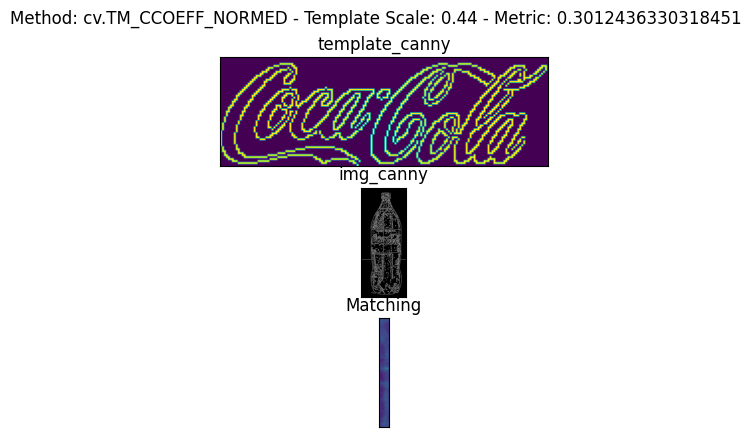

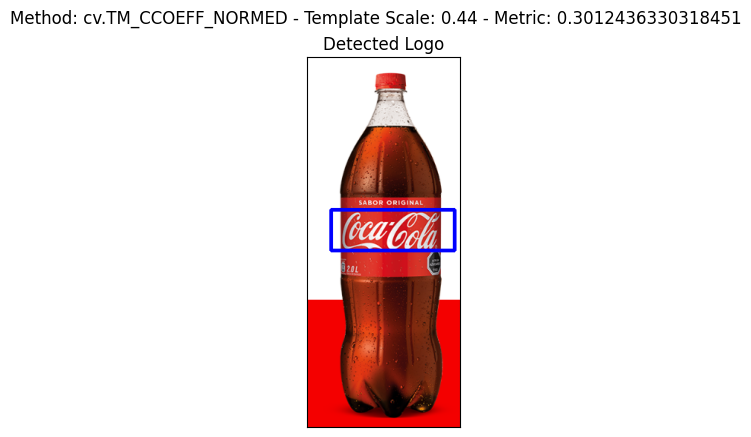

In [140]:
# Llamada a la función detectar
imagen = 1
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [0.38, 0.40, 0.42, 0.44, 0.46, 0.48, 0.50]
canny_threshold1_img = 50
canny_threshold2_img = 100
canny_threshold1_template = 50
canny_threshold2_template = 100


best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

# Gráficos de los resultados
plt.figure()
plt.subplot(311), plt.imshow(best_template_canny)
plt.title('template_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(img_canny, cmap='gray')
plt.title('img_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(best_res)
plt.title('Matching'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

plt.figure()
plt.imshow(img_salida)
plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()


el tamaño de la plantilla es mayor que la imagen


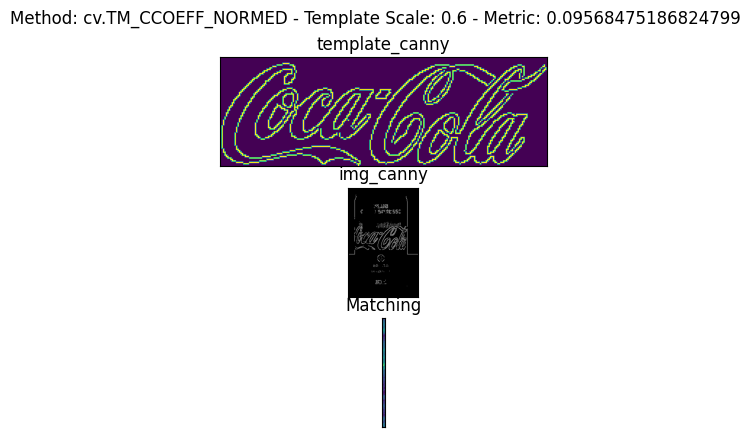

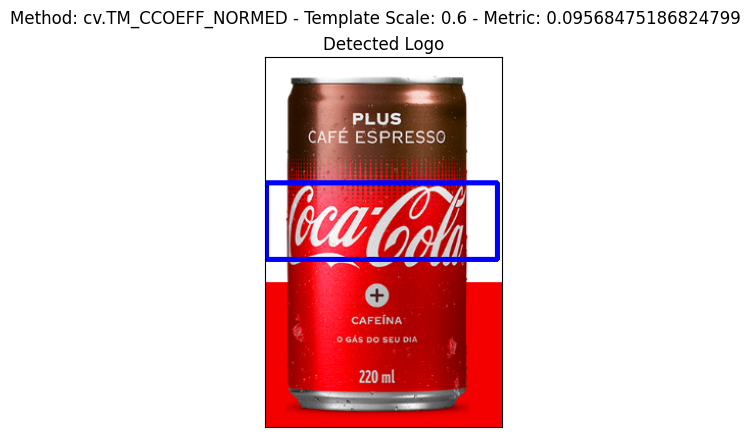

In [154]:
# Llamada a la función detectar
imagen = 2
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [0.4, 0.5, 0.6, 0.7]
canny_threshold1_img = 900
canny_threshold2_img = 925
canny_threshold1_template = 50
canny_threshold2_template = 100

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

# Gráficos de los resultados
plt.figure()
plt.subplot(311), plt.imshow(best_template_canny)
plt.title('template_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(img_canny, cmap='gray')
plt.title('img_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(best_res)
plt.title('Matching'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

plt.figure()
plt.imshow(img_salida)
plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

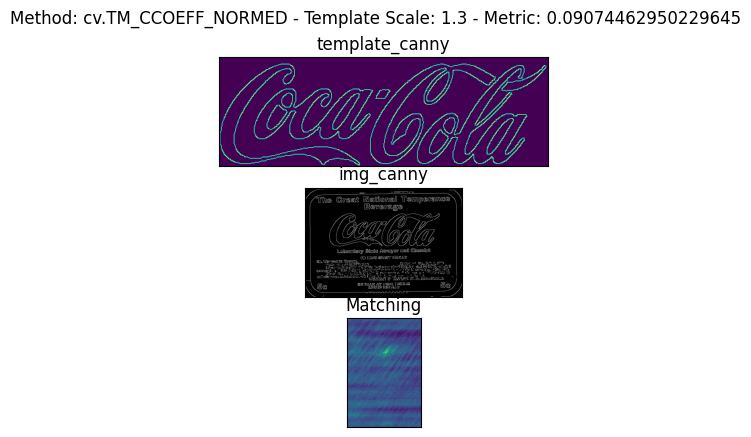

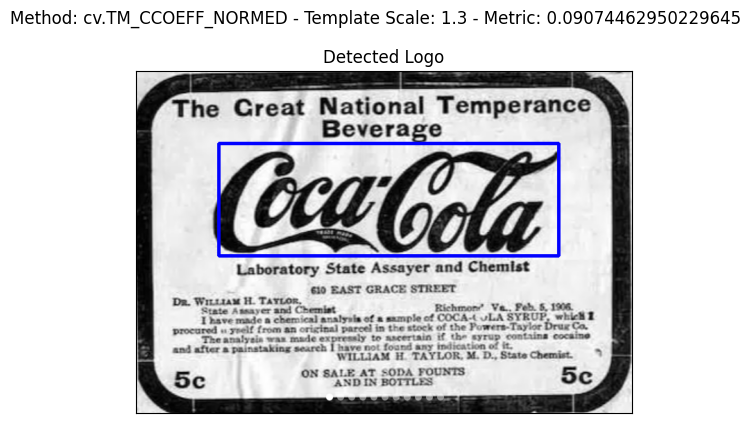

In [202]:
# Llamada a la función detectar
imagen = 4
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.9, 1, 1.2, 1.3, 1.4]
canny_threshold1_img = 400
canny_threshold2_img = 400
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

# Gráficos de los resultados
plt.figure()
plt.subplot(311), plt.imshow(best_template_canny)
plt.title('template_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(img_canny, cmap='gray')
plt.title('img_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(best_res)
plt.title('Matching'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

plt.figure()
plt.imshow(img_salida)
plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

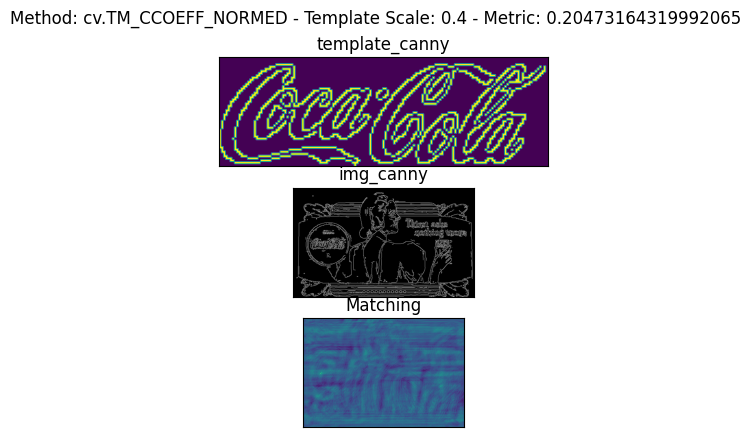

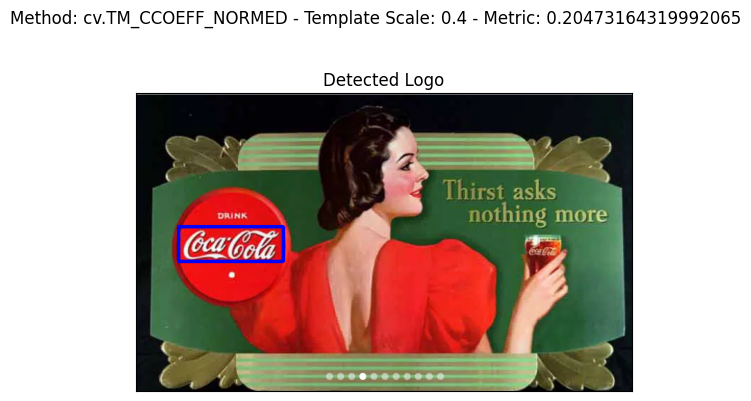

In [204]:
# Llamada a la función detectar
imagen = 5
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.3, 0.4, 0.5, 0.6]
canny_threshold1_img = 100
canny_threshold2_img = 50
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

# Gráficos de los resultados
plt.figure()
plt.subplot(311), plt.imshow(best_template_canny)
plt.title('template_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(img_canny, cmap='gray')
plt.title('img_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(best_res)
plt.title('Matching'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

plt.figure()
plt.imshow(img_salida)
plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

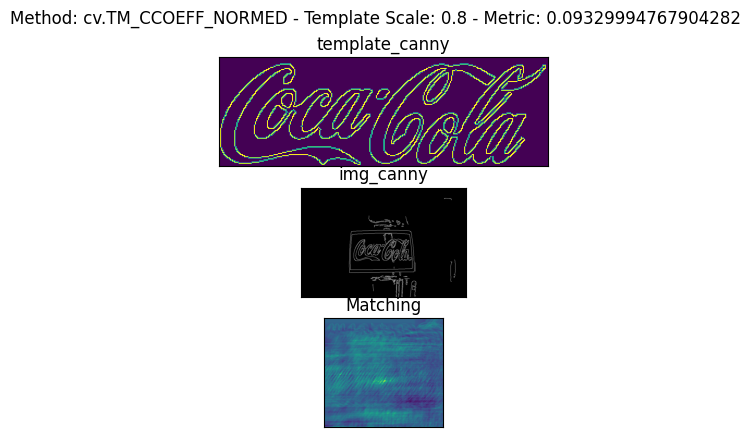

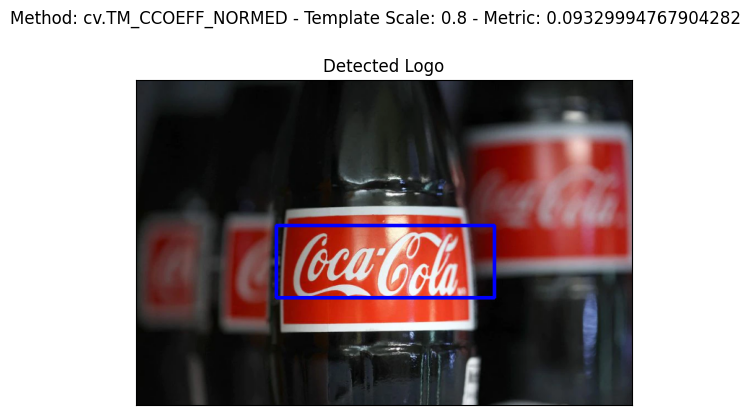

In [210]:
# Llamada a la función detectar
imagen = 6
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [ 0.4, 0.6, 0.8, 0.9, 1, 1.25]
canny_threshold1_img = 200
canny_threshold2_img = 100
canny_threshold1_template = 200
canny_threshold2_template = 100

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

# Gráficos de los resultados
plt.figure()
plt.subplot(311), plt.imshow(best_template_canny)
plt.title('template_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(img_canny, cmap='gray')
plt.title('img_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(best_res)
plt.title('Matching'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

plt.figure()
plt.imshow(img_salida)
plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

# =============================================================

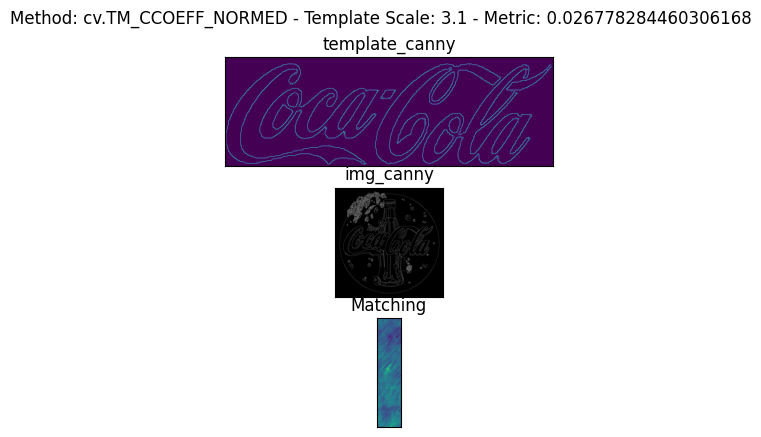

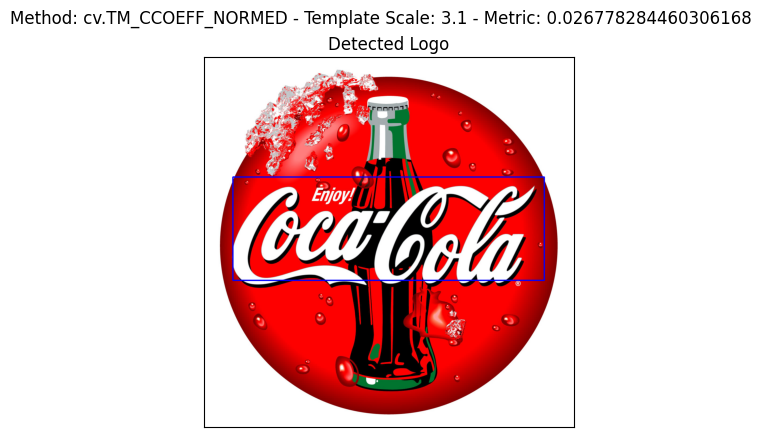

In [237]:
# Llamada a la función detectar
imagen = 0
img_color = images_info[imagen]['imagen_rgb']
img_gray = images_info[imagen]['imagen_gris']

metodo = 'cv.TM_CCOEFF_NORMED'
scale_list = [2.8, 2.9, 3, 3.1, 3.3 ]
canny_threshold1_img = 200
canny_threshold2_img = 200
canny_threshold1_template = 100
canny_threshold2_template = 50

best_template_canny, img_canny, best_res, img_salida, best_val, best_scale = detectar_logo(img_gray, img_color, template_gray, metodo, scale_list, canny_threshold1_img, canny_threshold2_img, canny_threshold1_template, canny_threshold2_template )

# Gráficos de los resultados
plt.figure()
plt.subplot(311), plt.imshow(best_template_canny)
plt.title('template_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(312), plt.imshow(img_canny, cmap='gray')
plt.title('img_canny'), plt.xticks([]), plt.yticks([])
plt.subplot(313), plt.imshow(best_res)
plt.title('Matching'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

plt.figure()
plt.imshow(img_salida)
plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])
plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")
plt.show()

method:  5
------------- 
best_val antes if:  0
max_val:  0.0992557555437088
new best_val:  0.0992557555437088
scale:  0.6


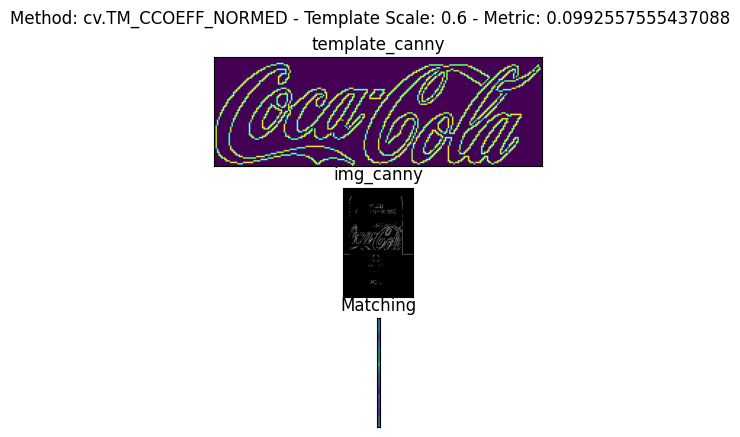

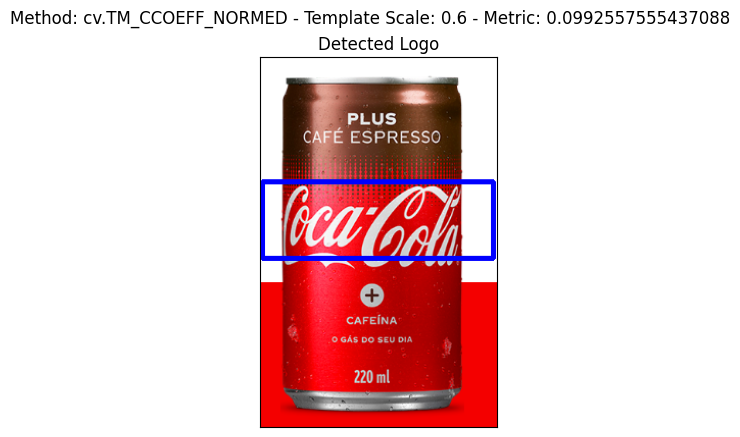

In [131]:
# eleccion de la imagen a procesar
imagen = 2

# Definimos el método para la detección
metodo = 'cv.TM_CCOEFF_NORMED'
method = eval(metodo)
print("method: " , method)

# Imagen en escala de grises de la imagen a procesar
img_gray = images_info[imagen]['imagen_gris']

# Iteramos sobre diferentes tamaños de la plantilla (mayores y menores) y obtenemos la mejor deteccion

## inicializacion de varibles
if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']:
    best_val  = 1
else: 
    best_val  = 0

for scale in [0.6]: 
    
    # Re-escalado de del template
    template_scaled = cv.resize(template_gray, None, fx=scale, fy=scale)
    # Si el tamaño de la plantilla es mayor que la imagen, dejamos de iterar
    if template_scaled.shape[0] > img_gray.shape[0] or template_scaled.shape[1] > img_gray.shape[1]:
        print("el tamaño de la plantilla es mayor que la imagen")
        break
        
    # Copia de la imagen
    img_salida = images_info[imagen]['imagen_rgb'].copy()

    # Aplico el Detector de Canny
    # Aplico Canny
    img_canny = cv.Canny(img_salida, threshold1=1000, threshold2=1000)

    # Aplico el Detector de Canny
    template_canny = cv.Canny(template_scaled, threshold1=50, threshold2=100)

    # Aplicamos el template matching con la plantilla redimensionada
    res = cv.matchTemplate(img_canny, template_canny, method)

    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    print("------------- ")
    # print("max_val antes if: ", abs(max_val))
    # print("max_loc antes if: ", max_loc)

    # Busco la mejor detección
    if metodo in ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']: # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el min_val
        # print("  ")
        # print("best_val: ", best_val)
        # print("scale: ", scale)
        # print("min_val: ", abs(min_val))
        if abs(min_val) < best_val:
            print("abs(min_val) < best_val: siiiiiii")
            best_val = abs(min_val)
            print("  ")
            print("new best_val: ", best_val)
            top_left = min_loc
            print("  ")
            print("top_left: ", top_left)
            best_res = res
            best_template_canny = template_canny
    else:
        # print("metodo in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED] >>>>>> nooooo")
        # print("  ")
        print("best_val antes if: ", best_val)
        # print("scale: ", scale)
        print("max_val: ", abs(max_val))
        if max_val > best_val:
            best_val = max_val
            print("new best_val: ", best_val)
            top_left = max_loc
            best_res = res
            best_template_canny = template_canny
            best_scale = scale
            print("scale: ", best_scale)
        ######

# Marcamos el lugar donde se encontró la coincidencia
w, h = best_template_canny.shape[::-1]

bottom_right = (top_left[0] + w, top_left[1] + h)

cv.rectangle(img_salida, 
             top_left, 
             bottom_right, 
             (0, 0, 255), 
             3)

# Graficación
plt.figure()

plt.subplot(311), plt.imshow(best_template_canny)
plt.title('template_canny'), plt.xticks([]), plt.yticks([])    

plt.subplot(312), plt.imshow(img_canny, cmap='gray')
plt.title('img_canny'), plt.xticks([]), plt.yticks([])

plt.subplot(313), plt.imshow(best_res)
plt.title('Matching'), plt.xticks([]), plt.yticks([])

plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")

plt.show()

# Muestra el procesamiento para cada escala de la plantilla
plt.figure()

plt.imshow(img_salida)
plt.title('Detected Logo'), plt.xticks([]), plt.yticks([])

plt.suptitle(f"Method: {metodo} - Template Scale: {best_scale} - Metric: {best_val}")

plt.show()




TypeError: Can't parse 'bboxes'. Sequence item with index 0 has a wrong type